# Random Forest

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import data_processing
import feature_extraction

In [3]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)
df = data_processing.drop_unlabelled(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

In [4]:
df = data_processing.create_segments(df)
df = data_processing.calculations(df)
df = data_processing.filter(df)

In [5]:
feature_df=feature_extraction.extract_features(df)
feature_df = feature_extraction.clean_features(feature_df)

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [8]:
# Separate features and labels
X = feature_df.drop(columns=['label', 'trajectory', 'segment'])  # Features
y = feature_df['label']               # Target

# Encode labels (if they are strings)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=36
)

In [11]:
# Initialize Decision Tree classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=36)

# Train the model (no need for feature scaling!)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))

Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

        bike      0.862     0.843     0.852       356
         bus      0.818     0.754     0.785       525
         car      0.810     0.689     0.745       383
       train      0.824     0.652     0.728       230
        walk      0.875     0.992     0.930      1148

    accuracy                          0.851      2642
   macro avg      0.838     0.786     0.808      2642
weighted avg      0.848     0.851     0.846      2642



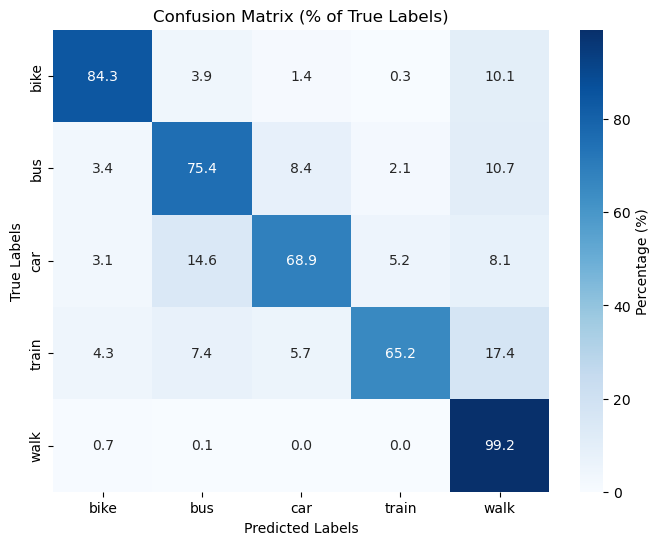

In [16]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize by true labels (rows)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Percentage (%)'})

plt.title('Confusion Matrix (% of True Labels)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Cross-Validation

In [20]:
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [None, 10, 20, 30],       # Maximum tree depth
    'min_samples_split': [2, 5, 10],       # Minimum samples to split node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples at leaf node
    'max_features': ['sqrt', 'log2', None], # Features considered for splits
    'bootstrap': [True, False],            # Bootstrap sampling  
}

In [21]:
rf = RandomForestClassifier(random_state=19, n_jobs=-1)

In [23]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,            # Use all available cores
    verbose=2,             # Detailed logging
    refit=True             # Refit best model on entire dataset
)

# Run grid search
grid_search.fit(X_train, y_train)  

# Best model evaluation
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.3f}")
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimator

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.850

Test Accuracy: 0.852


In [ ]:
# Get feature importances
importances = best_rf.feature_importances_
feature_names = X.columns

# Create DataFrame and sort for top features
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = fi_df.nlargest(10, 'Importance')  # Get top 10 features
top_features = top_features.sort_values('Importance', ascending=True)  # Reverse for plotting

# Create a dictionary of custom labels (feature_name_in_data: "Pretty Label")
custom_labels = {
    'top_1_speed': 'Max. Speed',
    'speed_std': 'Speed Std.',
    'expected_speed': 'Exp. Speed',
    'mean_speed': 'Average Speed',
    'trajectory_length': 'Segment length',
    'total_distance': 'Total distance',
    'jerk_std': 'Jerk Std.',
    'acceleration_std': 'Acceleration Std.',
    'acceleration_kurtosis': 'Acceleration Kurtosis',
    'speed_skewness': 'Speed Skewness',
    'top_3_speed': 'Top 3 Speed',
    'top_2_speed': 'Top 2 Speed',
    'acc_autocorr': 'Accel. Autocorr.',
    'top_1_acceleration': 'Max. Acceleration',
    'speed_kurtosis': 'Speed Kurtosis',
    'speed_autocorr': 'Speed Autocorr.'
}


# Apply custom labels
top_features['pretty_label'] = top_features['Feature'].map(lambda x: custom_labels.get(x, x))

# Plot using matplotlib
plt.figure(figsize=(7, 4))
plt.barh(
    top_features['pretty_label'],
    top_features['Importance'],
    color='orange',
    edgecolor='black'
)

plt.xlabel('Importance Score')
plt.title('')
plt.tight_layout()
plt.savefig('rf_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'best_rf' is not defined

Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

        bike      0.865     0.848     0.857       356
         bus      0.817     0.756     0.785       525
         car      0.809     0.687     0.743       383
       train      0.819     0.648     0.723       230
        walk      0.877     0.993     0.931      1148

    accuracy                          0.852      2642
   macro avg      0.837     0.786     0.808      2642
weighted avg      0.849     0.852     0.847      2642



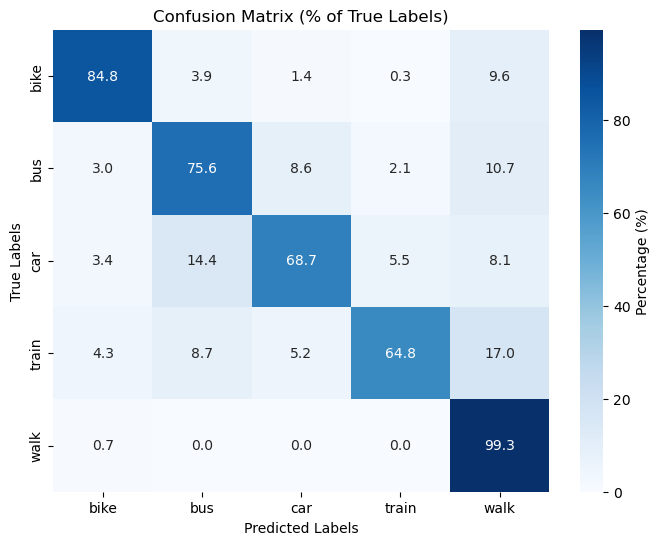

In [27]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize by true labels (rows)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Percentage (%)'})

plt.title('Confusion Matrix (% of True Labels)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

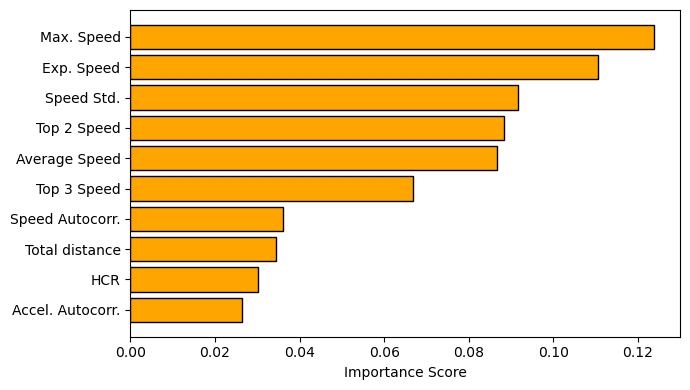